# Random search and hyperparameter scaling with SageMaker XGBoost and Automatic Model Tuning

### Contents
- Introduction
- Preparation
- Download and prepare the data
- Setup hyperparameter tuning
- Logarithmic scaling
- Random search
- Linear scaling

## Introduction
The goal is to implement a hyperparameter tuned model to predict the bank customers likely to sign a loan.

This notebook showcases the use of two hyperparameter tuning features: random search and hyperparameter scaling.

We will use SageMaker Python SDK, a high level SDK, to simplify the way we interact with SageMaker Hyperparameter Tuning.

## S3 Data and IAM Role Preparation
Let's start by specifying:

The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as SageMaker training.
The IAM role used to give training access to your data. See SageMaker documentation for how to create these.

In [1]:
!pip install -U seaborn

Keyring is skipped due to an exception: 'keyring.backends'


In [2]:
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
import os
from time import gmtime, strftime

import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

In [3]:
region = boto3.Session().region_name
smclient = boto3.Session().client("sagemaker")

role = sagemaker.get_execution_role()

#bucket = sagemaker.Session().default_bucket()
bucket = "bank-marketing-ml-sagemaker"
prefix = "sagemaker/DEMO-hpo-xgboost-dm"

In [4]:
pd.set_option("display.max_columns", 500)  # Make sure we can see all of the columns
pd.set_option("display.max_rows", 50)  # Keep the output on one page

## Download and prepare the data
Here we download the direct marketing dataset from UCI's ML Repository.

Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
- bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
- bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
- bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
- bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

In [5]:
#!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#!unzip -o data.zip

Now let us load the data, apply some preprocessing, and upload the processed data to s3

In [6]:
# Load data
data = pd.read_csv("./data/bank-additional-full.csv", sep=";")

## Exploratory Data Analysis

In [7]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Attribute Information:

Input variables:

bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')

related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')


Relevant Papers:
- S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014
- S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimaraes, Portugal, October, 2011. EUROSIS.

In [8]:
# columns that should not be included in the input
data = data.drop(
    ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
    axis=1,
)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          41188 non-null  int64 
 1   job          41188 non-null  object
 2   marital      41188 non-null  object
 3   education    41188 non-null  object
 4   default      41188 non-null  object
 5   housing      41188 non-null  object
 6   loan         41188 non-null  object
 7   contact      41188 non-null  object
 8   month        41188 non-null  object
 9   day_of_week  41188 non-null  object
 10  campaign     41188 non-null  int64 
 11  pdays        41188 non-null  int64 
 12  previous     41188 non-null  int64 
 13  poutcome     41188 non-null  object
 14  y            41188 non-null  object
dtypes: int64(4), object(11)
memory usage: 4.7+ MB


In [10]:
# seperate data into numeric and categorical columns
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()
numeric_columns

['age', 'campaign', 'pdays', 'previous']

In [11]:
categorical_columns = data.select_dtypes(exclude=np.number).columns.tolist()
categorical_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

### Visualize numeric features

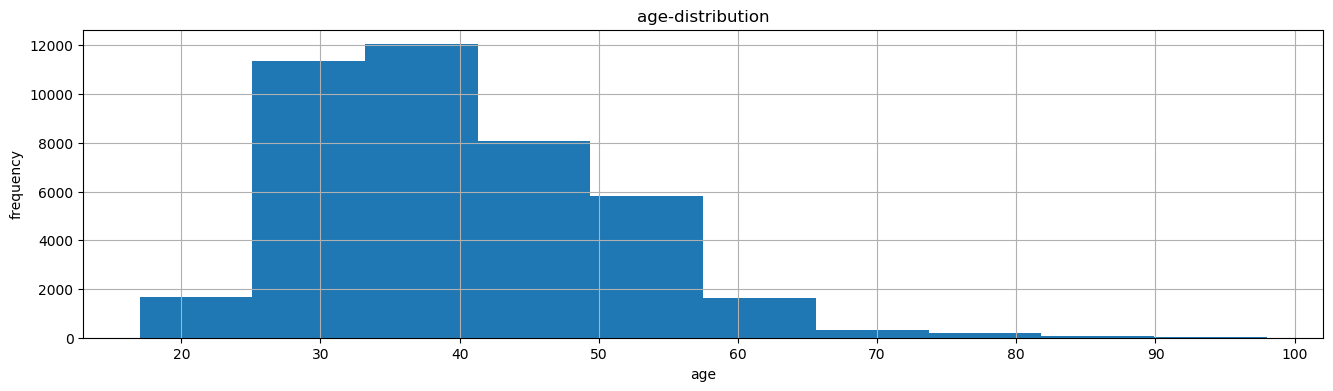

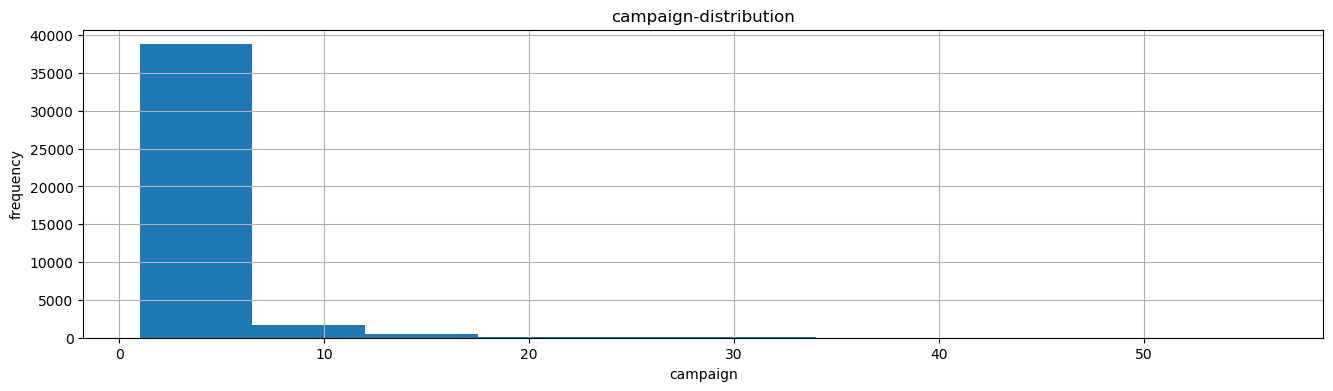

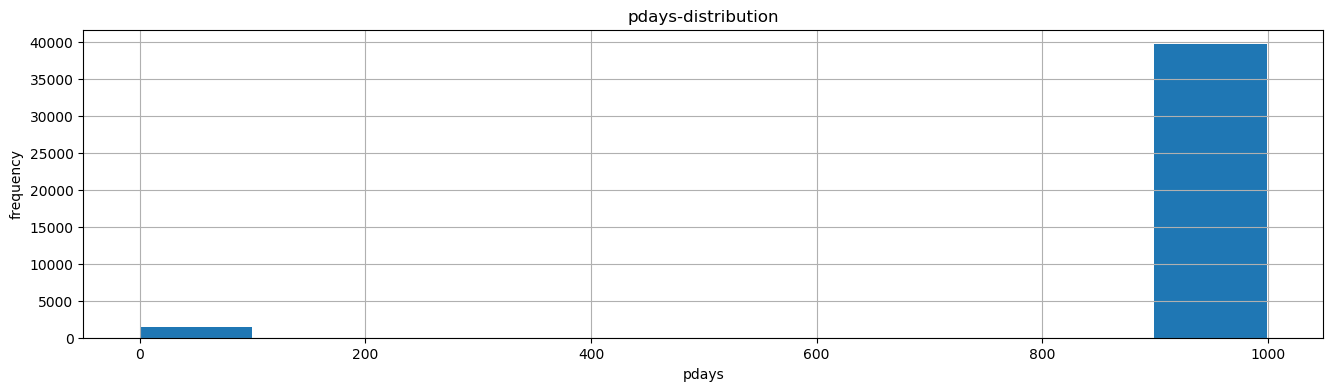

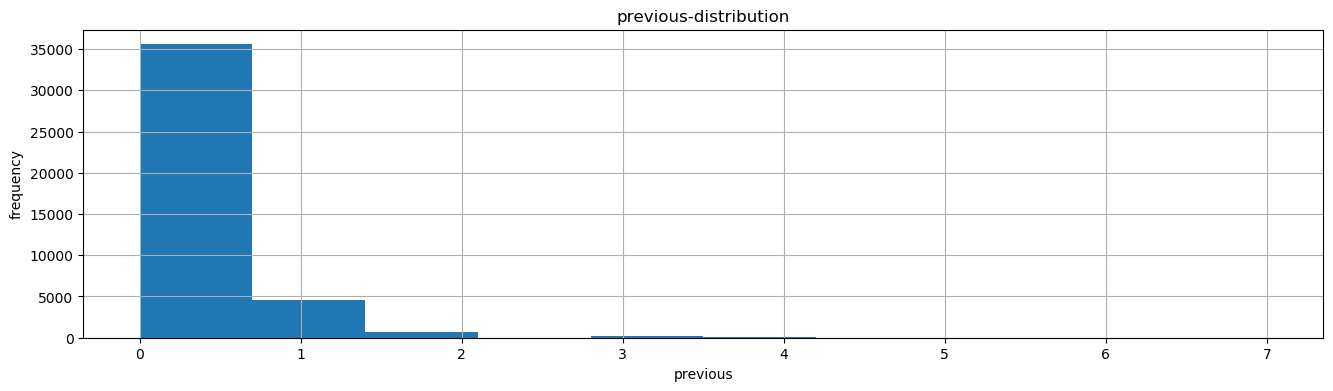

In [12]:
# let´s look at the distributions of the numeric columns

for col in numeric_columns:
    data[col].hist(figsize=(16, 4))
    plt.xlabel(col)
    plt.ylabel('frequency')
    plt.title(col + '-distribution')
    plt.grid(True)
    plt.show()

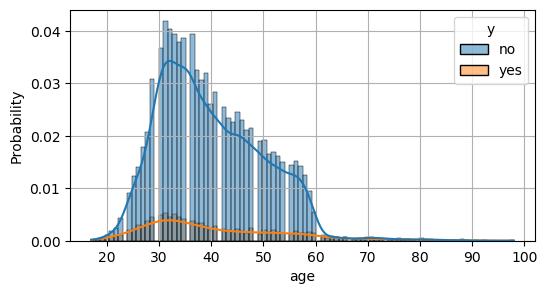

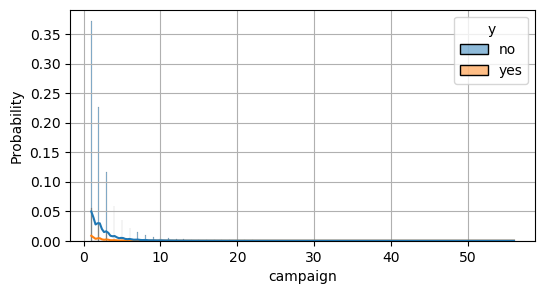

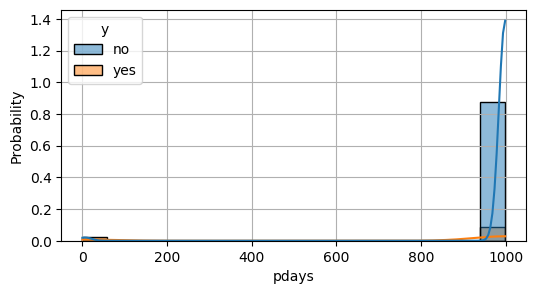

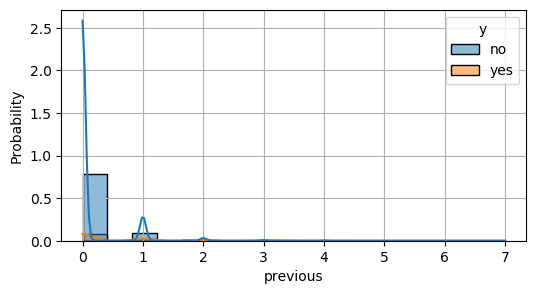

In [13]:
# let´s look at the histograms of the numeric features stratifying by the target value

for col in numeric_columns:
    f, ax = plt.subplots(figsize=(6, 3))
    sns.histplot(
            data=data, 
            x=col,
            hue='y',
            kde=True,
            stat='probability',
            ax=ax)
    plt.grid()
    plt.show()

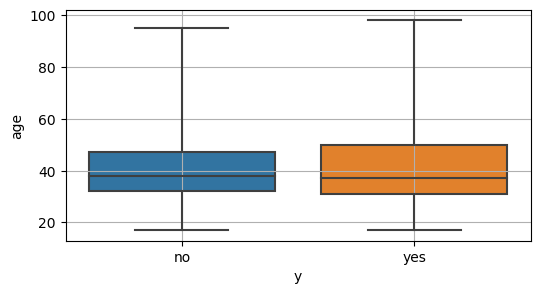

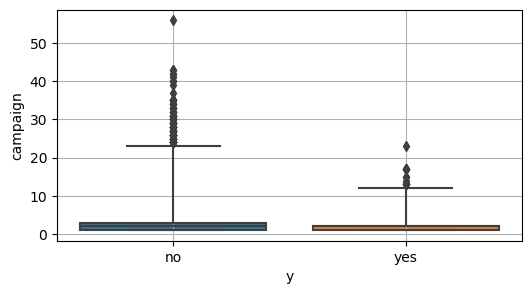

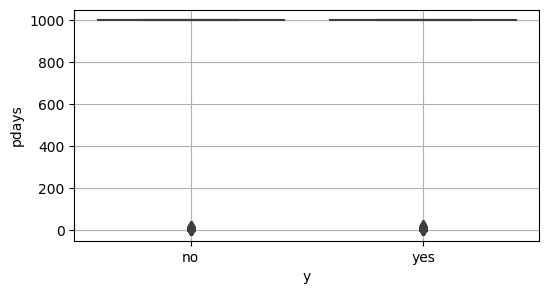

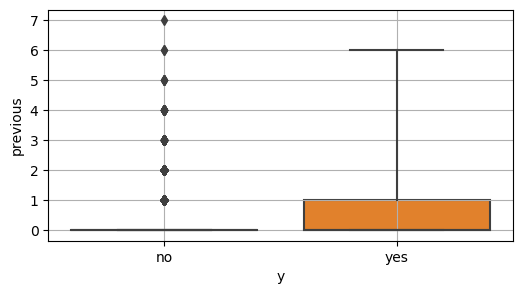

In [14]:
# let´s box-plot the numeric features stratifying by the target value

for col in numeric_columns:
    f, ax = plt.subplots(figsize=(6, 3))
    sns.boxplot(data=data, 
                y=col, 
                x='y',
                whis=10.0,
               ax=ax)
    plt.grid()
    plt.show()

In [15]:
# let´s check person correlation for numeric features
correlation_matrix = data[numeric_columns].corr()
correlation_matrix

,age,campaign,pdays,previous
age,1.000000,0.004594,-0.034369,0.024365
campaign,0.004594,1.000000,0.052584,-0.079141
pdays,-0.034369,0.052584,1.000000,-0.587514
previous,0.024365,-0.079141,-0.587514,1.000000


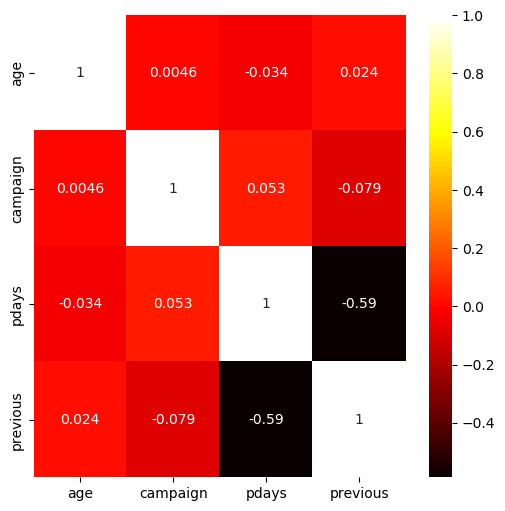

In [16]:
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(correlation_matrix, 
            cmap="hot", 
            annot=True,
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            ax=ax)
plt.show()

### Visualize categorical features

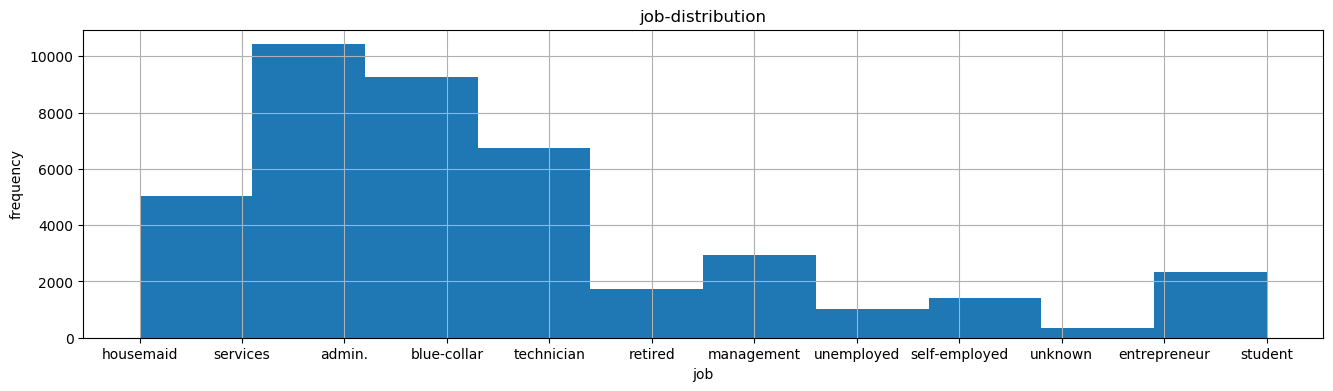

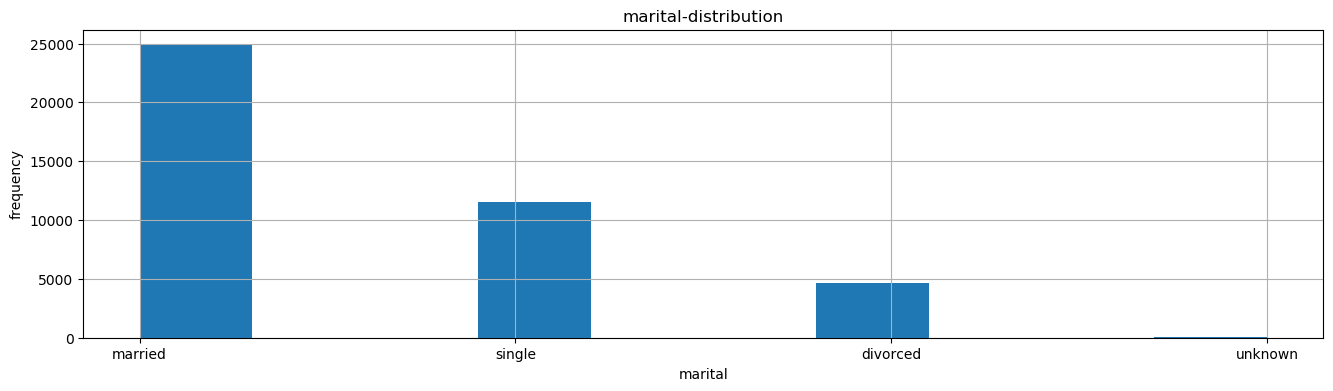

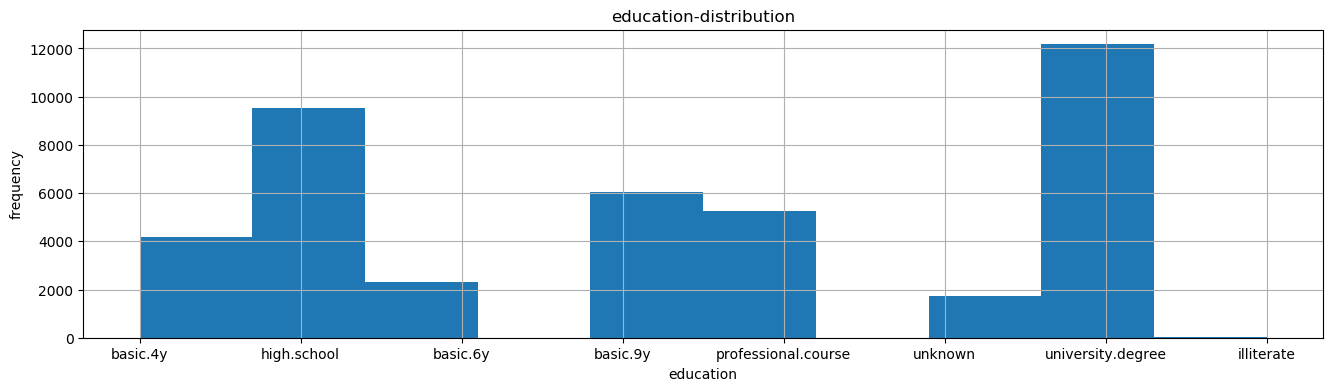

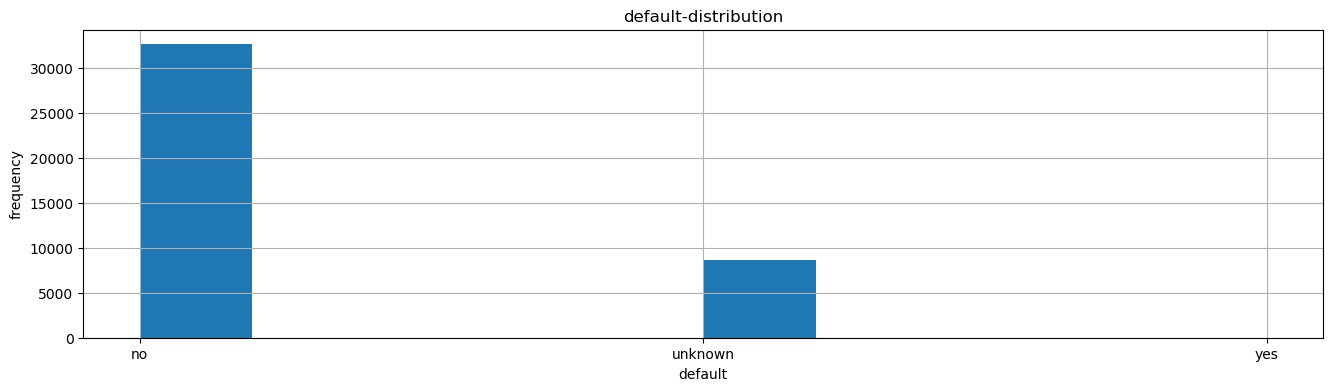

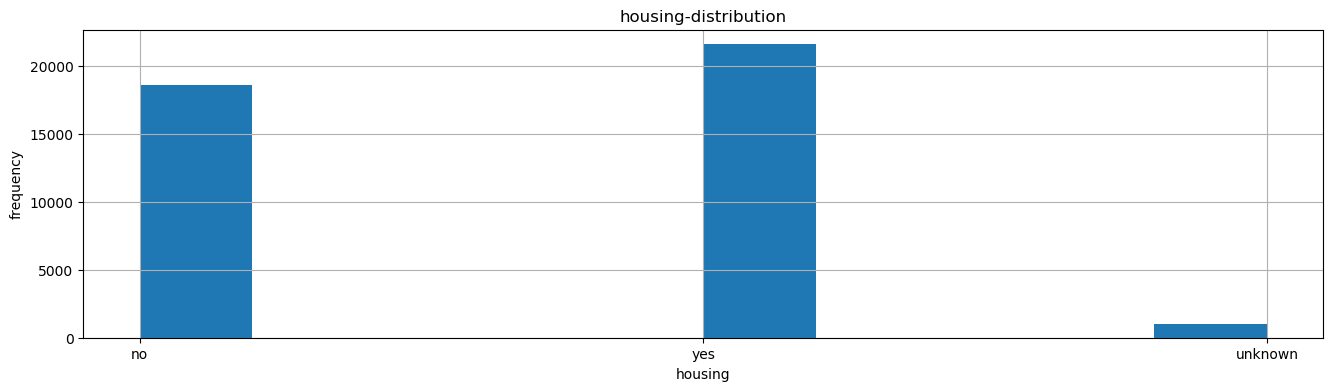

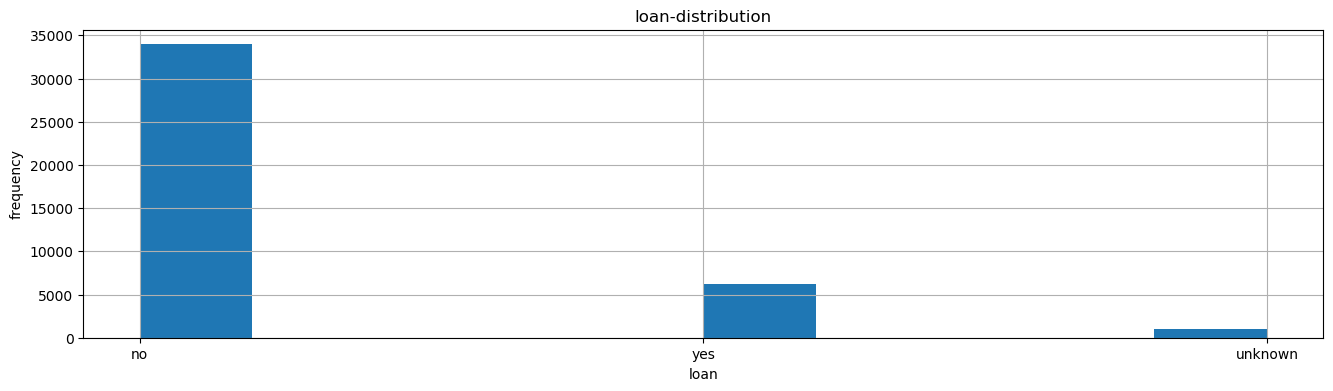

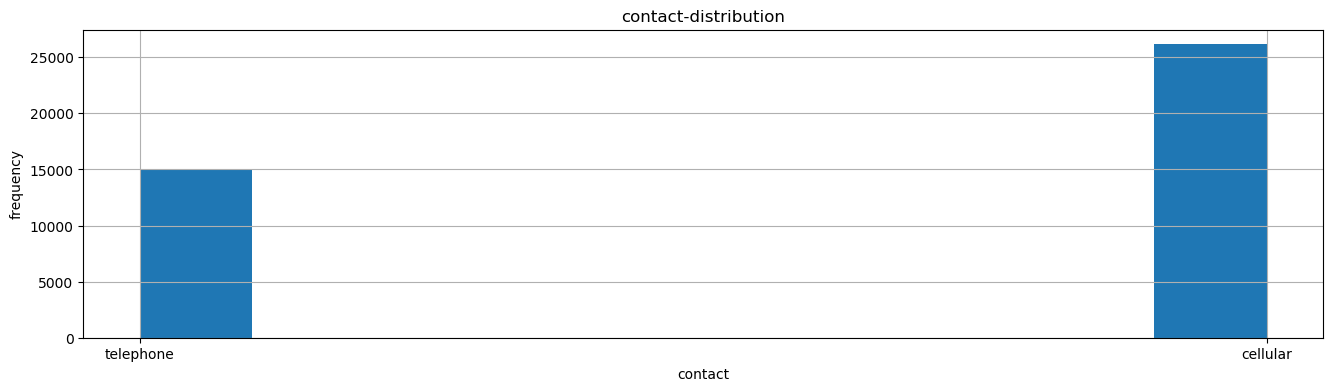

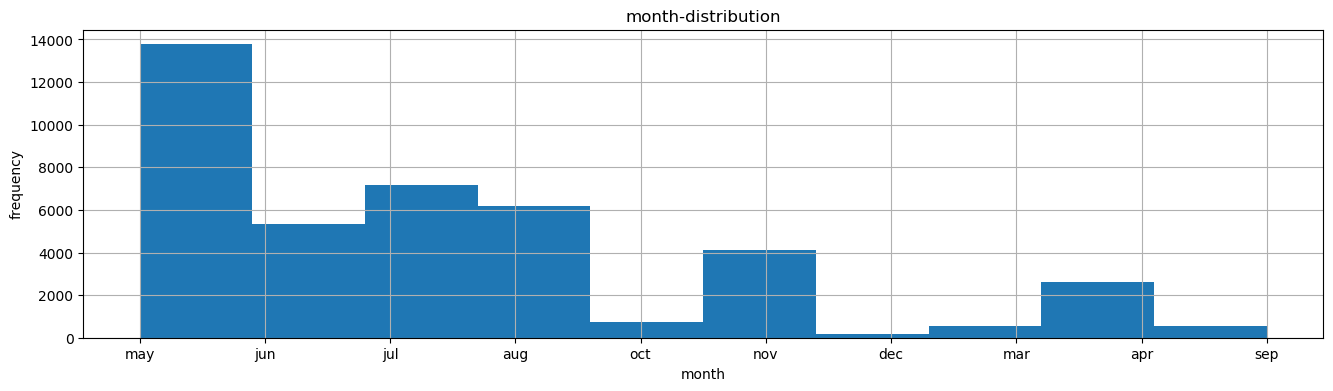

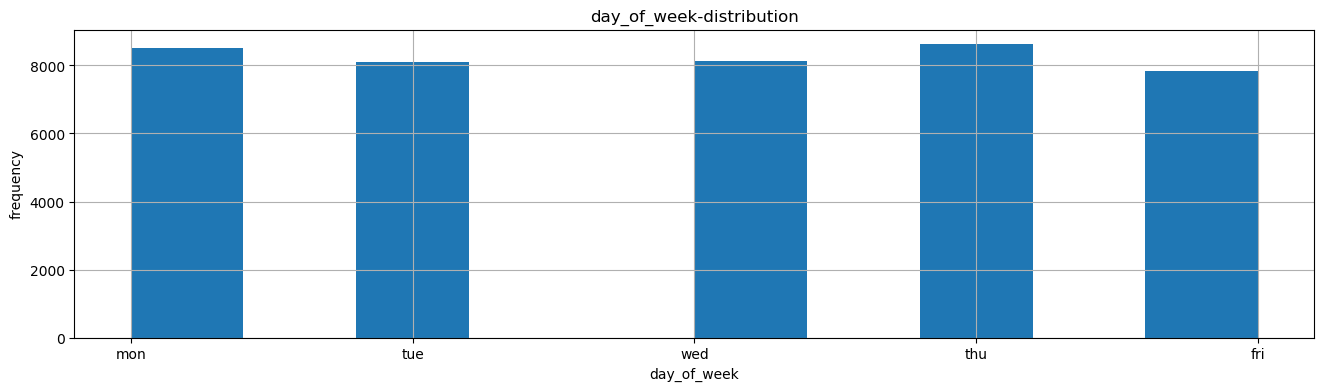

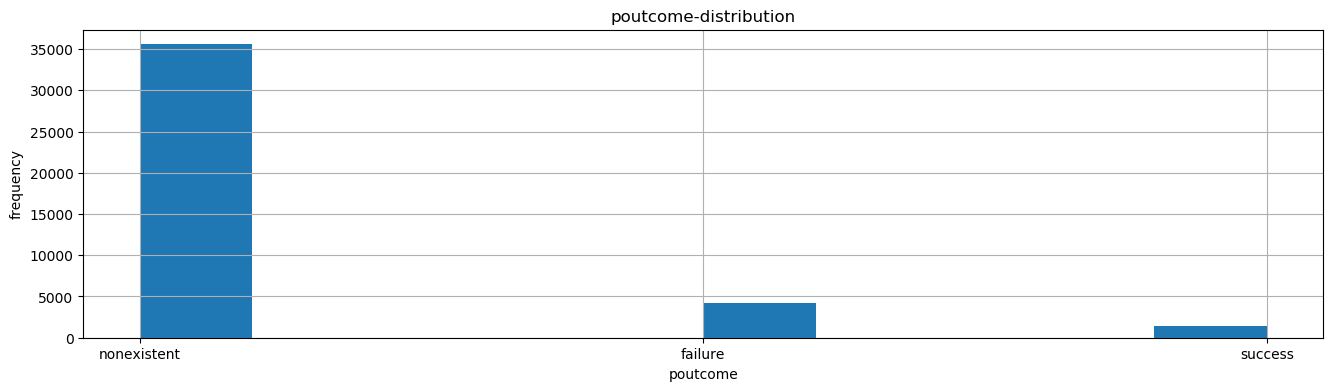

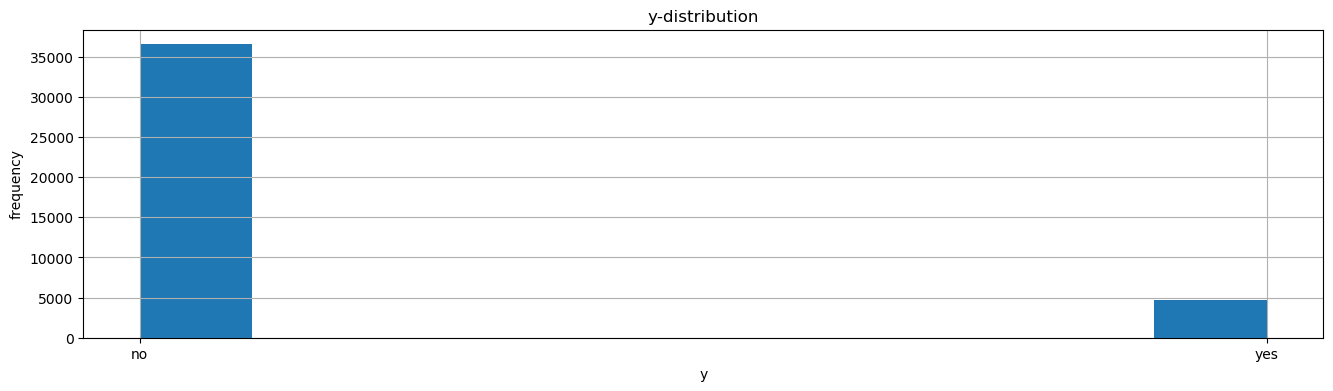

In [17]:
# let´s look at the distributions of the categorical columns

for col in categorical_columns:
    data[col].hist(figsize=(16, 4))
    plt.xlabel(col)
    plt.ylabel('frequency')
    plt.title(col + '-distribution')
    plt.grid(True)
    plt.show()

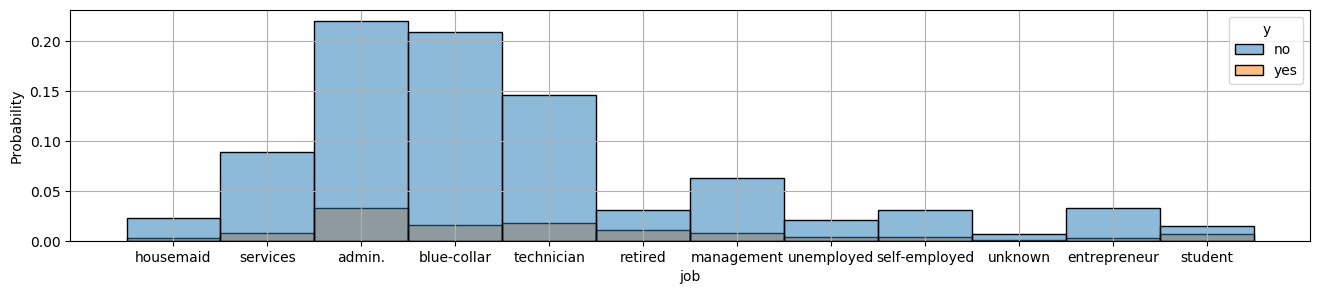

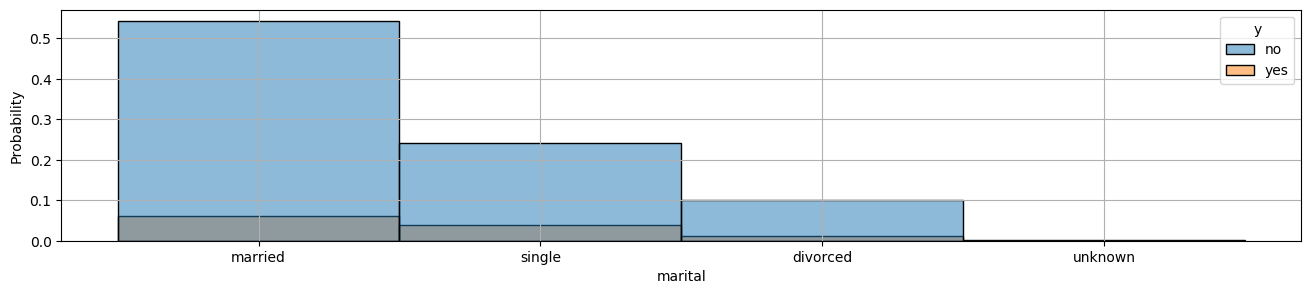

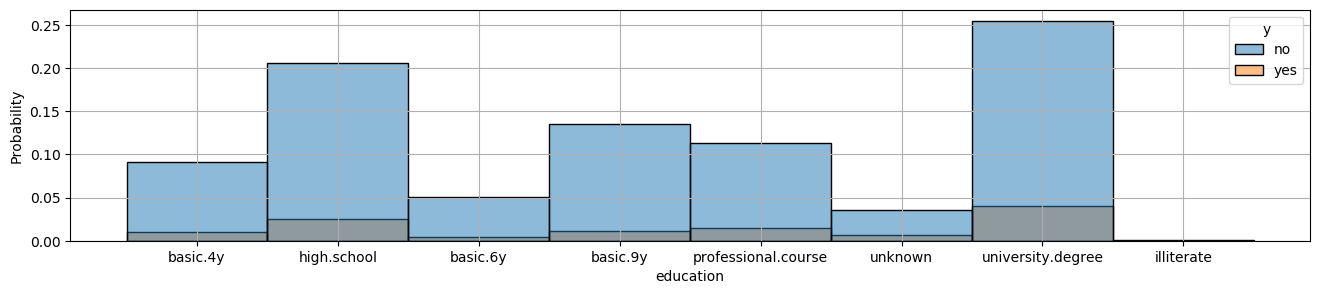

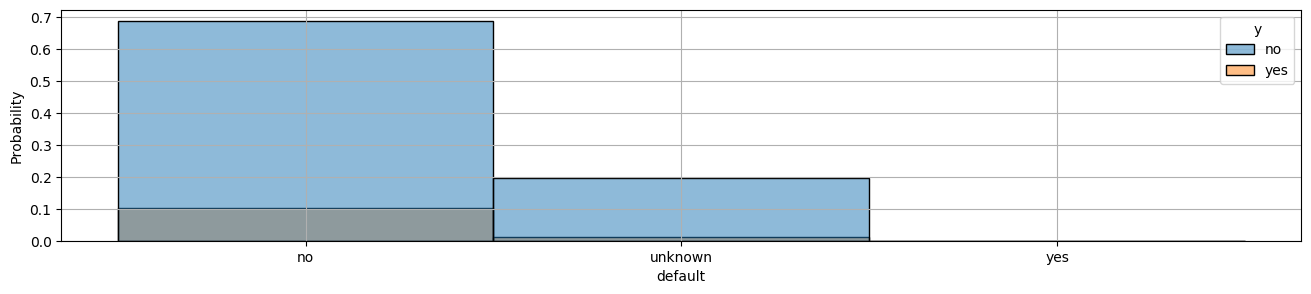

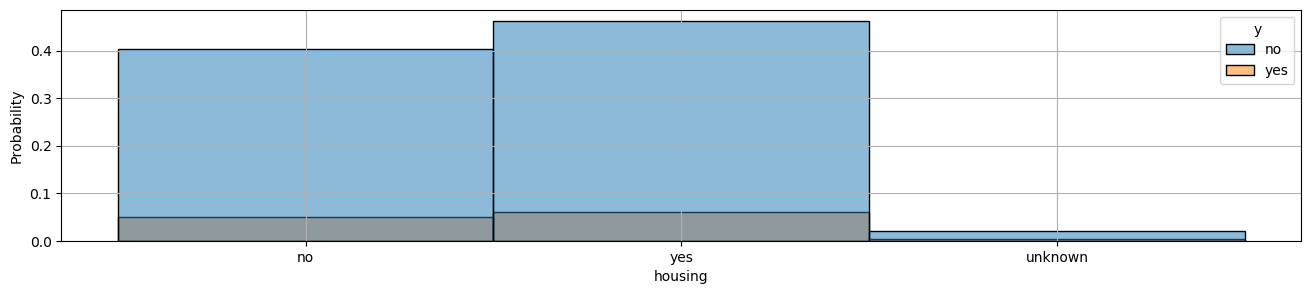

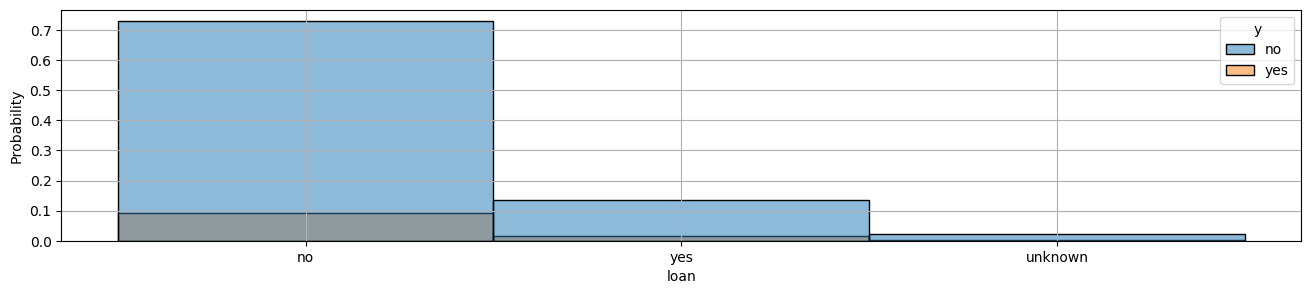

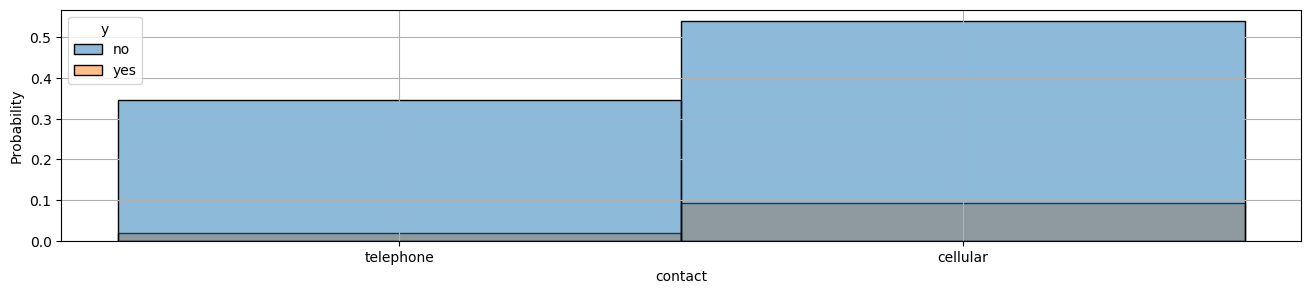

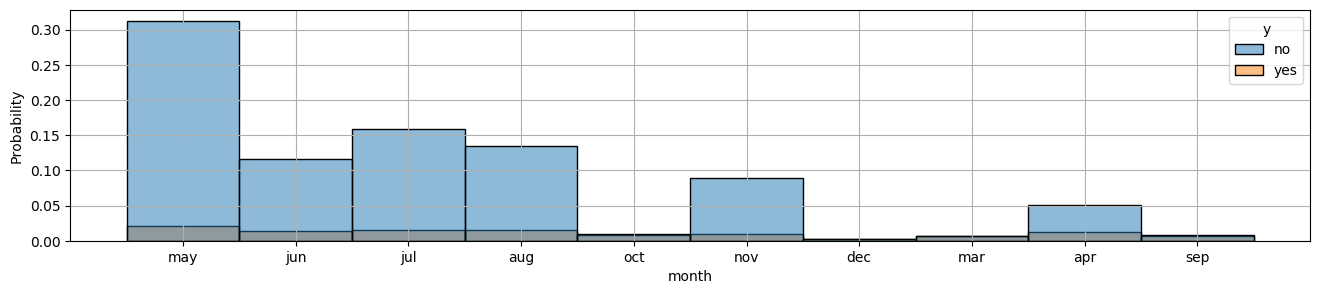

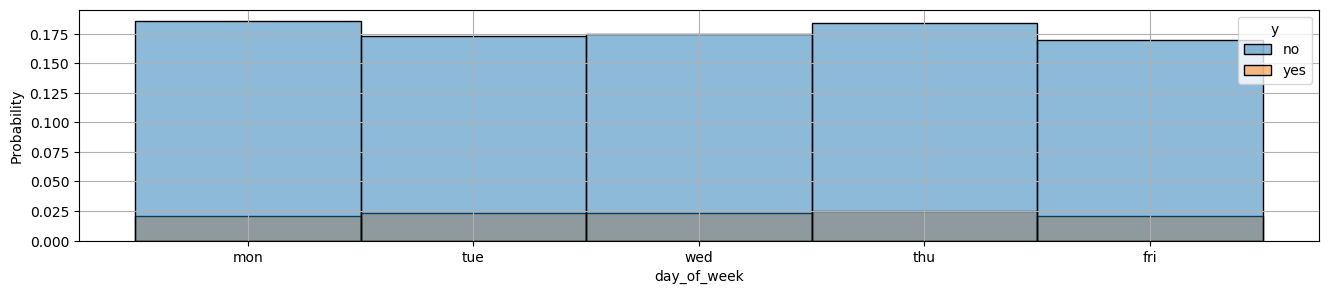

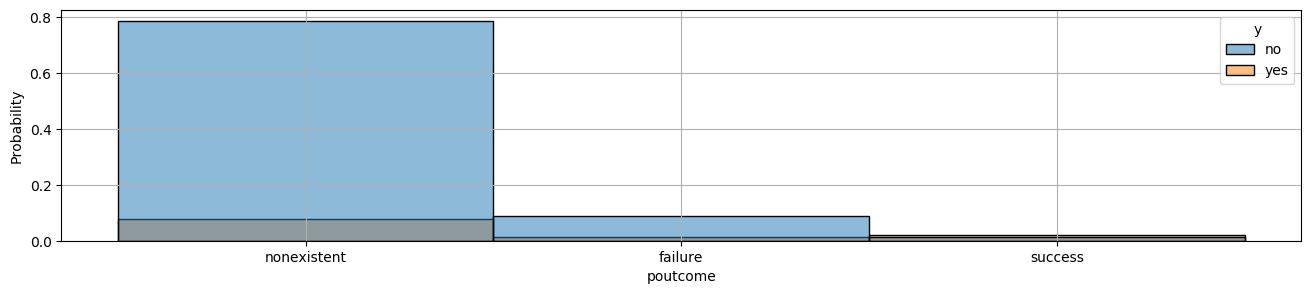

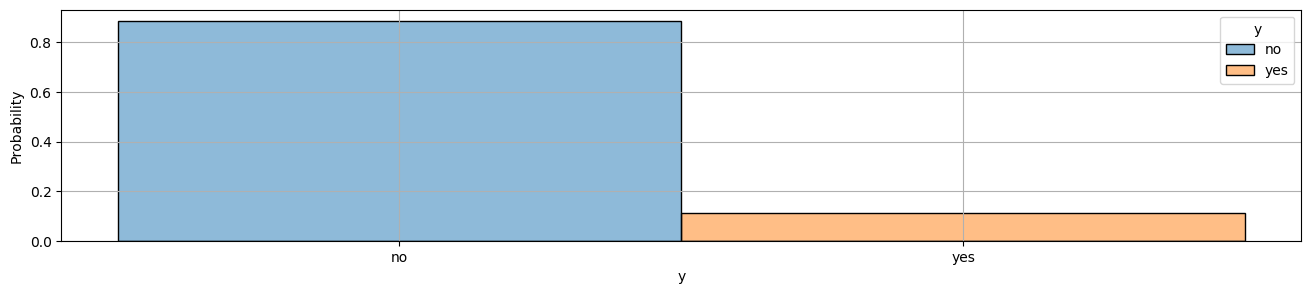

In [18]:
# let´s look at the histograms of the categorical features stratifying by the target value

for col in categorical_columns:
    f, ax = plt.subplots(figsize=(16, 3))
    sns.histplot(
            data=data, 
            x=col,
            hue='y',
            stat='probability',
            ax=ax)
    plt.grid()
    plt.show()

## Feature Engineering

In [19]:
# Apply some feature processing
data["no_previous_contact"] = np.where(
    data["pdays"] == 999, 1, 0
)  # Indicator variable to capture when pdays takes a value of 999
data["not_working"] = np.where(
    np.in1d(data["job"], ["student", "retired", "unemployed"]), 1, 0
)  # Indicator for individuals not actively employed
model_data = pd.get_dummies(data)  # Convert categorical variables to sets of indicators

